<a href="https://colab.research.google.com/github/enatan1/python-repo-/blob/main/SoftMpute_method_for_binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fancyimpute


  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 2.5 MB/s eta 0:00:00
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29879 sha256=d6e60877bab01947716b95b0cce177bdd965ffa4e829f6d5eac8d31d4caecf86
  Stored in directory: /root/.cache/pip/wheels/df/20/91/e4850b9a31cf660c1bc95515d3bcbc8010e869e5de6d5baf07
  Created wheel for knnimpute: filename=knnimpute-0.1.0-py3-none-any.whl size=11331 sha256=f17dcf8726a7311d90c24eef8b42c6a213883df039f8c2502100326a061709b4
  Stored in directory: /root/.cache/pip/wheels/89/11/61/aa5a3167bfff49218cd043a73a83034b9eadd858b0059521be
Successfully built fancyimpute knnimpute


In [6]:
from google.colab import files
uploaded = files.upload()


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
import os
import numpy as np
import pandas as pd

from fancyimpute import SoftImpute

from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import precision_recall_curve
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# ============================================================
# 0) Helper: mask test 1s AND proportional 0s (random)
# ============================================================
def create_proportional_mask(
    base_matrix: np.ndarray,
    pairs_df: pd.DataFrame,
    mask_indices: np.ndarray,
    total_ones: int,
    random_state: int = 42
) -> np.ndarray:
    """
    base_matrix: matrix to start from (float, may already contain NaNs)
    pairs_df: dataframe with columns [host_idx, parasite_idx, label]
    mask_indices: indices (rows) in pairs_df to consider as "held-out/test"
    total_ones: number of 1s in the ORIGINAL matrix (constant across folds)
    random_state: RNG seed

    Masking rule:
      - Mask ALL 1s among the held-out indices (set to NaN)
      - Mask a proportional number of 0s: if held-out contains k ones,
        p = k / total_ones, then mask ~p of ALL zeros (randomly).
      - Only mask zeros that are currently 0 (not already NaN).
    """
    rng = np.random.default_rng(random_state)
    Xm = base_matrix.astype(float).copy()

    held = pairs_df.iloc[mask_indices]
    held_ones = held[held["label"] == 1]
    k = len(held_ones)

    # Mask the held-out ones
    for _, r in held_ones.iterrows():#iteration over rows
        i = int(r["host_idx"])       #extract matrix row index
        j = int(r["parasite_idx"])   #extract matrix column index
        Xm[i, j] = np.nan            #mask the matrix entry

    # Proportional 0 masking (random)
    if total_ones > 0 and k > 0:     #Decide whether to do proportional zero masking
        p = k / total_ones

        # Eligible zeros are entries that are exactly 0 and not already NaN
        zero_positions = np.argwhere((Xm == 0.0) & (~np.isnan(Xm)))
        n_zero_to_mask = int(p * len(zero_positions)) #How many zeros to mask

        if n_zero_to_mask > 0:
            chosen = rng.choice(len(zero_positions), size=n_zero_to_mask, replace=False)
            for idx in chosen:
                i, j = zero_positions[idx]
                Xm[i, j] = np.nan

    return Xm


# ============================================================
# 1) Helper: SoftImpute + SVD feature extraction
# ============================================================
def softimpute_then_svd(
    X_masked: np.ndarray,
    shrinkage_value: float,
    n_components: int,
    random_state: int = 42
):
    """
    Returns:
      U: (n_hosts, n_components) host embeddings
      V: (n_parasites, n_components) parasite embeddings
    """
    # SoftImpute creates a completed dense matrix (float)
    X_completed = SoftImpute(
        shrinkage_value=shrinkage_value,
        max_iters=200,
        convergence_threshold=1e-4,
        verbose=False
    ).fit_transform(X_masked)

    # SVD to get latent features
    svd = TruncatedSVD(n_components=n_components, random_state=random_state)
    U = svd.fit_transform(X_completed)     # host embeddings
    V = svd.components_.T                  # parasite embeddings

    return U, V

#the function converts host–parasite pairs into feature vectors using their latent embeddings.
def build_pair_features(pairs_df: pd.DataFrame, U: np.ndarray, V: np.ndarray) -> np.ndarray:
    """
    Feature vector for each pair (i,j):
      [U_i , V_j , dot(U_i, V_j)]
    """
    feats = []                                              #Initialize feature container
    for _, r in pairs_df.iterrows():                        #Loop over pairs
        i = int(r["host_idx"])                              #Extract host index
        j = int(r["parasite_idx"])                          #Extract parasite index
        ui = U[i]                                           #Get host embedding
        vj = V[j]                                           #Get parasite embedding
        feats.append(np.hstack([ui, vj, np.dot(ui, vj)]))   #Compute interaction score and stack into one feature vector
    return np.asarray(feats)


# ============================================================
# 2) Load and build binary matrix + cell table
# ============================================================
path = "/content/drive/MyDrive/DATA.xlsx"


df = pd.read_excel(path)

df_1984 = df[df["YearCollected"] == 1984].copy()                                                    #filter the year 1984
parasite_cols = df_1984.columns.drop(["YearCollected", "Host"])

presence_matrix = (df_1984[parasite_cols] > 0).astype(int)
prevalence_1984 = presence_matrix.groupby(df_1984["Host"]).mean()
binary_1984 = (prevalence_1984 > 0).astype(int)                                                      #build a binary data frame

A = binary_1984.values.astype(float)                                                                 #make A as a matrix to be with the values of binary_1984
n_hosts, n_parasites = A.shape                                                                       #get the shape of A

cell_df = pd.DataFrame({
    "host_idx": np.repeat(np.arange(n_hosts), n_parasites),
    "parasite_idx": np.tile(np.arange(n_parasites), n_hosts),
})
cell_df["label"] = A[cell_df["host_idx"], cell_df["parasite_idx"]].astype(int)                       #build a data frame with all the combinations of Host x Paasite

total_ones = int(np.sum(A == 1.0))                                                                   #count how many 1's in A
print(f"Matrix shape: {A.shape}, total ones: {total_ones}, total zeros: {int(np.sum(A==0.0))}")


# ============================================================
# 3) Nested CV: Outer evaluation, Inner tuning
# ============================================================
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)                                 #build a outer loop with 5 folds
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)                                 #build inner loop with 3 folds

# Simple grids (keep small to start)
grid_shrinkage = [0.5, 1.0, 2.0]      # SoftImpute shrinkage strength
grid_rank = [5, 10, 20]               # SVD rank

outer_results = []

print("\nStarting leakage-safe nested CV (SoftImpute + SVD features + classifier)...")

for fold_idx, (train_val_idx, test_idx) in enumerate(outer_cv.split(cell_df, cell_df["label"]), start=1):
    print(f"\n=== Outer Fold {fold_idx} ===")

    # Outer-test masking (blindfold the pipeline)
    X_outer_masked = create_proportional_mask(
        base_matrix=A,
        pairs_df=cell_df,
        mask_indices=test_idx,
        total_ones=total_ones,
        random_state=42 + fold_idx
    )

    # Build inner dataframe (only outer-train cells)
    inner_df = cell_df.iloc[train_val_idx].reset_index(drop=True)

    best_params = None
    best_inner_auc = -np.inf

    # -------------------------
    # Inner loop: tune (shrinkage, rank)
    # -------------------------
    for sh in grid_shrinkage:       #test each (shrinkage, rank) combination.
        for rnk in grid_rank:
            inner_aucs = []

            for i_train, i_val in inner_cv.split(inner_df, inner_df["label"]):
                train_pairs = inner_df.iloc[i_train]
                val_pairs   = inner_df.iloc[i_val]

                # IMPORTANT: start from X_outer_masked so outer-test stays hidden
                X_inner_masked = create_proportional_mask(
                    base_matrix=X_outer_masked,
                    pairs_df=inner_df,
                    mask_indices=i_val,
                    total_ones=total_ones,
                    random_state=1000 + fold_idx
                )

                # SoftImpute + SVD
                U, V = softimpute_then_svd(
                    X_masked=X_inner_masked,
                    shrinkage_value=sh,
                    n_components=rnk,
                    random_state=42
                )

                # Features
                X_train = build_pair_features(train_pairs, U, V)
                y_train = train_pairs["label"].values

                X_val = build_pair_features(val_pairs, U, V)
                y_val = val_pairs["label"].values

                # Classifier (simple, strong baseline)
                clf = LogisticRegression(
                    max_iter=2000,
                    class_weight="balanced",
                    solver="lbfgs"
                )
                clf.fit(X_train, y_train)
                val_prob = clf.predict_proba(X_val)[:, 1]

                inner_aucs.append(roc_auc_score(y_val, val_prob))

            avg_auc = float(np.mean(inner_aucs))
            if avg_auc > best_inner_auc:
                best_inner_auc = avg_auc
                best_params = (sh, rnk)

    best_sh, best_rank = best_params
    print(f"Best inner params: shrinkage={best_sh}, rank={best_rank} | inner AUC={best_inner_auc:.4f}")

    # -------------------------
    # Final outer fold training/evaluation using best params
    # -------------------------
    U, V = softimpute_then_svd(
        X_masked=X_outer_masked,
        shrinkage_value=best_sh,
        n_components=best_rank,
        random_state=42
    )

    train_pairs = cell_df.iloc[train_val_idx]
    test_pairs  = cell_df.iloc[test_idx]

    X_train = build_pair_features(train_pairs, U, V)
    y_train = train_pairs["label"].values

    X_test = build_pair_features(test_pairs, U, V)
    y_test = test_pairs["label"].values

    clf = LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        solver="lbfgs"
    )
    clf.fit(X_train, y_train)

    test_prob = clf.predict_proba(X_test)[:, 1]
    test_pred = (test_prob >= 0.5).astype(int)

    auc = roc_auc_score(y_test, test_prob)
    f1 = f1_score(y_test, test_pred)

    outer_results.append({"auc": auc, "f1": f1, "params": best_params})
    print(f"Outer Fold {fold_idx} -> AUC: {auc:.4f}, F1: {f1:.4f}")


# ============================================================
# 4) Final summary
# ============================================================
mean_auc = np.mean([r["auc"] for r in outer_results])
std_auc  = np.std([r["auc"] for r in outer_results])

mean_f1 = np.mean([r["f1"] for r in outer_results])
std_f1  = np.std([r["f1"] for r in outer_results])

print("\n===== FINAL NESTED-CV RESULTS =====")
print(f"AUC: {mean_auc:.4f} ± {std_auc:.4f}")
print(f"F1 : {mean_f1:.4f} ± {std_f1:.4f}")

print("\nChosen params per fold:")
for i, r in enumerate(outer_results, start=1):
    sh, rk = r["params"]
    print(f"  Fold {i}: shrinkage={sh}, rank={rk}, AUC={r['auc']:.4f}, F1={r['f1']:.4f}")


/usr/local/lib/python3.12/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


Matrix shape: (21, 56), total ones: 396, total zeros: 780

Starting leakage-safe nested CV (SoftImpute + SVD features + classifier)...

=== Outer Fold 1 ===
Best inner params: shrinkage=2.0, rank=20 | inner AUC=0.9477
Outer Fold 1 -> AUC: 0.9694, F1: 0.7143

=== Outer Fold 2 ===
Best inner params: shrinkage=2.0, rank=20 | inner AUC=0.9422
Outer Fold 2 -> AUC: 0.9498, F1: 0.7302

=== Outer Fold 3 ===
Best inner params: shrinkage=2.0, rank=20 | inner AUC=0.9440
Outer Fold 3 -> AUC: 0.9797, F1: 0.7634

=== Outer Fold 4 ===
Best inner params: shrinkage=2.0, rank=20 | inner AUC=0.9356
Outer Fold 4 -> AUC: 0.9667, F1: 0.7302

=== Outer Fold 5 ===
Best inner params: shrinkage=2.0, rank=20 | inner AUC=0.9482
Outer Fold 5 -> AUC: 0.9554, F1: 0.7143

===== FINAL NESTED-CV RESULTS =====
AUC: 0.9642 ± 0.0106
F1 : 0.7304 ± 0.0179

Chosen params per fold:
  Fold 1: shrinkage=2.0, rank=20, AUC=0.9694, F1=0.7143
  Fold 2: shrinkage=2.0, rank=20, AUC=0.9498, F1=0.7302
  Fold 3: shrinkage=2.0, rank=20, 

In [14]:
import os
import numpy as np
import pandas as pd
import warnings
from fancyimpute import SoftImpute
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score

# 1. Mute warnings for a cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# ============================================================
# HELPER FUNCTIONS
# ============================================================

def create_proportional_mask(base_matrix, pairs_df, mask_indices, total_ones, random_state=42):
    rng = np.random.default_rng(random_state)
    Xm = base_matrix.astype(float).copy()
    held = pairs_df.iloc[mask_indices]
    held_ones = held[held["label"] == 1]

    # Mask held-out ones
    for _, r in held_ones.iterrows():
        Xm[int(r["host_idx"]), int(r["parasite_idx"])] = np.nan

    # Proportional zero masking
    if total_ones > 0 and len(held_ones) > 0:
        p = len(held_ones) / total_ones
        zero_positions = np.argwhere((Xm == 0.0) & (~np.isnan(Xm)))
        n_to_mask = int(p * len(zero_positions))
        if n_to_mask > 0:
            chosen = rng.choice(len(zero_positions), size=n_to_mask, replace=False)
            for idx in chosen:
                Xm[zero_positions[idx][0], zero_positions[idx][1]] = np.nan
    return Xm

def softimpute_then_svd(X_masked, shrinkage, n_components, seed=42):
    X_completed = SoftImpute(shrinkage_value=shrinkage, max_iters=200, verbose=False).fit_transform(X_masked)
    svd = TruncatedSVD(n_components=n_components, random_state=seed)
    U = svd.fit_transform(X_completed)
    V = svd.components_.T
    return U, V

def build_pair_features(pairs_df, U, V):
    feats = []
    for _, r in pairs_df.iterrows():
        i, j = int(r["host_idx"]), int(r["parasite_idx"])
        ui, vj = U[i], V[j]
        feats.append(np.hstack([ui, vj, np.dot(ui, vj)]))
    return np.asarray(feats)

# ============================================================
# DATA PREPARATION
# ============================================================

path = "/content/drive/MyDrive/DATA.xlsx"
df = pd.read_excel(path)
df_1984 = df[df["YearCollected"] == 1984].copy()
parasite_cols = df_1984.columns.drop(["YearCollected", "Host"])

binary_1984 = (df_1984.groupby("Host")[parasite_cols].mean() > 0).astype(int)
A = binary_1984.values.astype(float)
n_hosts, n_parasites = A.shape

cell_df = pd.DataFrame({
    "host_idx": np.repeat(np.arange(n_hosts), n_parasites),
    "parasite_idx": np.tile(np.arange(n_parasites), n_hosts),
})
cell_df["label"] = A[cell_df["host_idx"], cell_df["parasite_idx"]].astype(int)
total_ones = int(np.sum(A == 1.0))

# ============================================================
# NESTED CROSS-VALIDATION WITH HYPERPARAMETER TUNING
# ============================================================

outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# --- HYPERPARAMETER GRIDS ---
grid_shrinkage = [1.0, 2.0, 4.0]
grid_rank      = [10, 20, 30]
grid_C         = [0.1, 1.0, 10.0]        # Inverse Regularization Strength
grid_weights   = ["balanced", None]      # Class Weight options

outer_results = []

print(f"Starting Nested CV on Matrix {A.shape}...")

for fold_idx, (train_val_idx, test_idx) in enumerate(outer_cv.split(cell_df, cell_df["label"]), 1):
    print(f"\n--- Outer Fold {fold_idx} ---")

    X_outer_masked = create_proportional_mask(A, cell_df, test_idx, total_ones, 42 + fold_idx)
    inner_df = cell_df.iloc[train_val_idx].reset_index(drop=True)

    best_params = None
    best_inner_auc = -np.inf

    # --- INNER LOOP: TUNING ---
    for sh in grid_shrinkage:
        for rnk in grid_rank:
            # We only do SoftImpute/SVD once per (sh, rnk) to save time
            for i_train, i_val in inner_cv.split(inner_df, inner_df["label"]):
                X_inner_masked = create_proportional_mask(X_outer_masked, inner_df, i_val, total_ones, 100)
                U_inner, V_inner = softimpute_then_svd(X_inner_masked, sh, rnk)

                X_tr_inner = build_pair_features(inner_df.iloc[i_train], U_inner, V_inner)
                X_val_inner = build_pair_features(inner_df.iloc[i_val], U_inner, V_inner)
                y_tr_inner = inner_df.iloc[i_train]["label"].values
                y_val_inner = inner_df.iloc[i_val]["label"].values

                for c_val in grid_C:
                    for w in grid_weights:
                        clf = LogisticRegression(C=c_val, class_weight=w, max_iter=2000)
                        clf.fit(X_tr_inner, y_tr_inner)
                        val_prob = clf.predict_proba(X_val_inner)[:, 1]
                        score = roc_auc_score(y_val_inner, val_prob)

                        if score > best_inner_auc:
                            best_inner_auc = score
                            best_params = {'sh': sh, 'rnk': rnk, 'C': c_val, 'w': w}

    # --- OUTER EVALUATION ---
    print(f"Best Params: {best_params} | Inner AUC: {best_inner_auc:.4f}")

    U, V = softimpute_then_svd(X_outer_masked, best_params['sh'], best_params['rnk'])
    X_train_final = build_pair_features(cell_df.iloc[train_val_idx], U, V)
    X_test_final = build_pair_features(cell_df.iloc[test_idx], U, V)
    y_train_final = cell_df.iloc[train_val_idx]["label"].values
    y_test_final = cell_df.iloc[test_idx]["label"].values

    final_clf = LogisticRegression(C=best_params['C'], class_weight=best_params['w'], max_iter=2000)
    final_clf.fit(X_train_final, y_train_final)

    test_prob = final_clf.predict_proba(X_test_final)[:, 1]
    auc = roc_auc_score(y_test_final, test_prob)
    f1 = f1_score(y_test_final, (test_prob >= 0.5))

    outer_results.append({"auc": auc, "f1": f1, "params": best_params})
    print(f"Fold {fold_idx} Result -> AUC: {auc:.4f}, F1: {f1:.4f}")

# --- SUMMARY ---
print("\n===== FINAL RESULTS =====")
print(f"Mean AUC: {np.mean([r['auc'] for r in outer_results]):.4f}")
print(f"Mean F1:  {np.mean([r['f1'] for r in outer_results]):.4f}")

Starting Nested CV on Matrix (21, 56)...

--- Outer Fold 1 ---
Best Params: {'sh': 2.0, 'rnk': 20, 'C': 1.0, 'w': None} | Inner AUC: 0.9604
Fold 1 Result -> AUC: 0.9688, F1: 0.6935

--- Outer Fold 2 ---
Best Params: {'sh': 2.0, 'rnk': 30, 'C': 10.0, 'w': 'balanced'} | Inner AUC: 0.9601
Fold 2 Result -> AUC: 0.9521, F1: 0.6885

--- Outer Fold 3 ---
Best Params: {'sh': 2.0, 'rnk': 30, 'C': 1.0, 'w': None} | Inner AUC: 0.9635
Fold 3 Result -> AUC: 0.9759, F1: 0.7097

--- Outer Fold 4 ---
Best Params: {'sh': 4.0, 'rnk': 20, 'C': 10.0, 'w': None} | Inner AUC: 0.9555
Fold 4 Result -> AUC: 0.9654, F1: 0.4762

--- Outer Fold 5 ---
Best Params: {'sh': 2.0, 'rnk': 20, 'C': 10.0, 'w': 'balanced'} | Inner AUC: 0.9624
Fold 5 Result -> AUC: 0.9577, F1: 0.6935

===== FINAL RESULTS =====
Mean AUC: 0.9640
Mean F1:  0.6523


In [15]:
# ============================================================
# FULL PIPELINE
# SoftImpute + SVD + Logistic Regression
# Nested CV with Recall-Controlled Thresholding
# ============================================================

import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    f1_score,
    precision_score,
    recall_score,
    precision_recall_curve
)

from fancyimpute import SoftImpute
from sklearn.decomposition import TruncatedSVD


# ============================================================
# 1) HELPER FUNCTIONS
# ============================================================

def create_proportional_mask(
    base_matrix: np.ndarray,
    pairs_df: pd.DataFrame,
    mask_indices: np.ndarray,
    total_ones: int,
    random_state: int = 42
) -> np.ndarray:
    rng = np.random.default_rng(random_state)
    Xm = base_matrix.astype(float).copy()

    held = pairs_df.iloc[mask_indices]
    held_ones = held[held["label"] == 1]
    k = len(held_ones)

    # Mask held-out positives
    for _, r in held_ones.iterrows():
        i = int(r["host_idx"])
        j = int(r["parasite_idx"])
        Xm[i, j] = np.nan

    # Mask proportional zeros
    if total_ones > 0 and k > 0:
        p = k / total_ones
        zero_positions = np.argwhere((Xm == 0.0) & (~np.isnan(Xm)))
        n_zero_to_mask = int(p * len(zero_positions))

        if n_zero_to_mask > 0:
            chosen = rng.choice(len(zero_positions), size=n_zero_to_mask, replace=False)
            for idx in chosen:
                i, j = zero_positions[idx]
                Xm[i, j] = np.nan

    return Xm


def softimpute_then_svd(
    X_masked: np.ndarray,
    shrinkage_value: float,
    n_components: int,
    random_state: int = 42
):
    X_completed = SoftImpute(
        shrinkage_value=shrinkage_value,
        max_iters=200,
        convergence_threshold=1e-4,
        verbose=False
    ).fit_transform(X_masked)

    svd = TruncatedSVD(n_components=n_components, random_state=random_state)
    U = svd.fit_transform(X_completed)
    V = svd.components_.T

    return U, V


def build_pair_features(
    pairs_df: pd.DataFrame,
    U: np.ndarray,
    V: np.ndarray
) -> np.ndarray:

    feats = []
    for _, r in pairs_df.iterrows():
        i = int(r["host_idx"])
        j = int(r["parasite_idx"])
        ui = U[i]
        vj = V[j]
        feats.append(np.hstack([ui, vj, np.dot(ui, vj)]))
    return np.asarray(feats)


def choose_threshold_by_recall(y_true, scores, target_recall=0.8):
    precision, recall, thresholds = precision_recall_curve(y_true, scores)
    valid = np.where(recall[1:] >= target_recall)[0]
    if len(valid) == 0:
        return 0.0
    return thresholds[valid[-1]]


# ============================================================
# 2) INPUT DATA (YOU MUST PREPARE THESE)
# ============================================================

# A: host × parasite matrix (binary or prevalence)
# cell_df: dataframe with columns:
#   ["host_idx", "parasite_idx", "label"]

# Example (REMOVE THIS WHEN USING REAL DATA)
# A = ...
# cell_df = ...

total_ones = int(np.sum(A == 1))


# ============================================================
# 3) PARAMETERS
# ============================================================

TARGET_RECALL = 0.8

grid_shrinkage = [0.5, 1.0, 2.0]
grid_rank = [5, 10, 20]

outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

outer_results = []


# ============================================================
# 4) NESTED CROSS-VALIDATION
# ============================================================

print("\nStarting full nested CV pipeline")

for fold_idx, (train_val_idx, test_idx) in enumerate(
    outer_cv.split(cell_df, cell_df["label"]), start=1
):

    print(f"\n=== Outer Fold {fold_idx} ===")

    # -------------------------
    # Mask outer test set
    # -------------------------
    X_outer_masked = create_proportional_mask(
        base_matrix=A,
        pairs_df=cell_df,
        mask_indices=test_idx,
        total_ones=total_ones,
        random_state=42 + fold_idx
    )

    inner_df = cell_df.iloc[train_val_idx].reset_index(drop=True)

    best_auc = -np.inf
    best_params = None

    # -------------------------
    # Inner CV: hyperparameter tuning
    # -------------------------
    for sh in grid_shrinkage:
        for rnk in grid_rank:
            aucs = []

            for i_tr, i_val in inner_cv.split(inner_df, inner_df["label"]):

                train_pairs = inner_df.iloc[i_tr]
                val_pairs   = inner_df.iloc[i_val]

                X_inner_masked = create_proportional_mask(
                    base_matrix=X_outer_masked,
                    pairs_df=inner_df,
                    mask_indices=i_val,
                    total_ones=total_ones,
                    random_state=1000 + fold_idx
                )

                U, V = softimpute_then_svd(
                    X_masked=X_inner_masked,
                    shrinkage_value=sh,
                    n_components=rnk,
                    random_state=42
                )

                X_train = build_pair_features(train_pairs, U, V)
                y_train = train_pairs["label"].values

                X_val = build_pair_features(val_pairs, U, V)
                y_val = val_pairs["label"].values

                clf = LogisticRegression(
                    max_iter=2000,
                    class_weight="balanced",
                    solver="lbfgs"
                )
                clf.fit(X_train, y_train)

                val_prob = clf.predict_proba(X_val)[:, 1]
                aucs.append(roc_auc_score(y_val, val_prob))

            mean_auc = np.mean(aucs)
            if mean_auc > best_auc:
                best_auc = mean_auc
                best_params = (sh, rnk)

    best_sh, best_rank = best_params
    print(f"Best inner params: shrinkage={best_sh}, rank={best_rank}")

    # -------------------------
    # Final training on outer-train
    # -------------------------
    U, V = softimpute_then_svd(
        X_masked=X_outer_masked,
        shrinkage_value=best_sh,
        n_components=best_rank,
        random_state=42
    )

    train_pairs = cell_df.iloc[train_val_idx]
    test_pairs  = cell_df.iloc[test_idx]

    X_train = build_pair_features(train_pairs, U, V)
    y_train = train_pairs["label"].values

    X_test = build_pair_features(test_pairs, U, V)
    y_test = test_pairs["label"].values

    clf = LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        solver="lbfgs"
    )
    clf.fit(X_train, y_train)

    # -------------------------
    # Recall-controlled threshold
    # -------------------------
    train_prob = clf.predict_proba(X_train)[:, 1]
    threshold = choose_threshold_by_recall(
        y_train, train_prob, target_recall=TARGET_RECALL
    )

    # -------------------------
    # Test evaluation
    # -------------------------
    test_prob = clf.predict_proba(X_test)[:, 1]
    test_pred = (test_prob >= threshold).astype(int)

    outer_results.append({
        "fold": fold_idx,
        "auc": roc_auc_score(y_test, test_prob),
        "f1": f1_score(y_test, test_pred),
        "precision": precision_score(y_test, test_pred),
        "recall": recall_score(y_test, test_pred),
        "threshold": threshold,
        "shrinkage": best_sh,
        "rank": best_rank
    })

    print(
        f"AUC={outer_results[-1]['auc']:.4f} | "
        f"Recall={outer_results[-1]['recall']:.3f} | "
        f"Precision={outer_results[-1]['precision']:.3f}"
    )


# ============================================================
# 5) FINAL SUMMARY
# ============================================================

results_df = pd.DataFrame(outer_results)
print("\n=== FINAL CV RESULTS (mean) ===")
print(results_df.mean(numeric_only=True))



Starting full nested CV pipeline

=== Outer Fold 1 ===
Best inner params: shrinkage=2.0, rank=20
AUC=0.9694 | Recall=0.025 | Precision=1.000

=== Outer Fold 2 ===
Best inner params: shrinkage=2.0, rank=20
AUC=0.9498 | Recall=0.051 | Precision=1.000

=== Outer Fold 3 ===
Best inner params: shrinkage=2.0, rank=20
AUC=0.9797 | Recall=0.051 | Precision=1.000

=== Outer Fold 4 ===
Best inner params: shrinkage=2.0, rank=20
AUC=0.9667 | Recall=0.063 | Precision=1.000

=== Outer Fold 5 ===
Best inner params: shrinkage=2.0, rank=20
AUC=0.9554 | Recall=0.114 | Precision=1.000

=== FINAL CV RESULTS (mean) ===
fold          3.000000
auc           0.964180
f1            0.113029
precision     1.000000
recall        0.060696
threshold     0.970582
shrinkage     2.000000
rank         20.000000
dtype: float64



Running CV with Fβ-based thresholding

=== Fold 1 ===
AUC=0.969 | Recall=0.562 | Precision=0.978 | thr=0.5096 | pred+=46/80

=== Fold 2 ===
AUC=0.950 | Recall=0.481 | Precision=1.000 | thr=0.7495 | pred+=38/79

=== Fold 3 ===
AUC=0.980 | Recall=0.266 | Precision=1.000 | thr=0.9088 | pred+=21/79

=== Fold 4 ===
AUC=0.967 | Recall=0.557 | Precision=0.978 | thr=0.5468 | pred+=45/79

=== Fold 5 ===
AUC=0.955 | Recall=0.342 | Precision=1.000 | thr=0.8700 | pred+=27/79


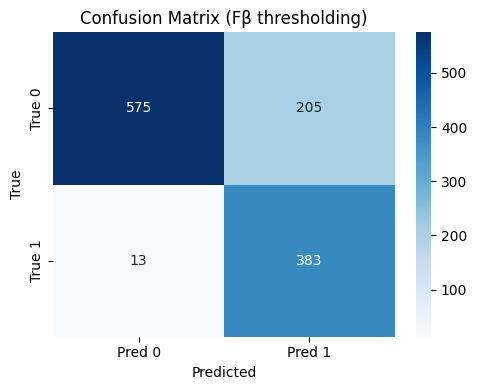

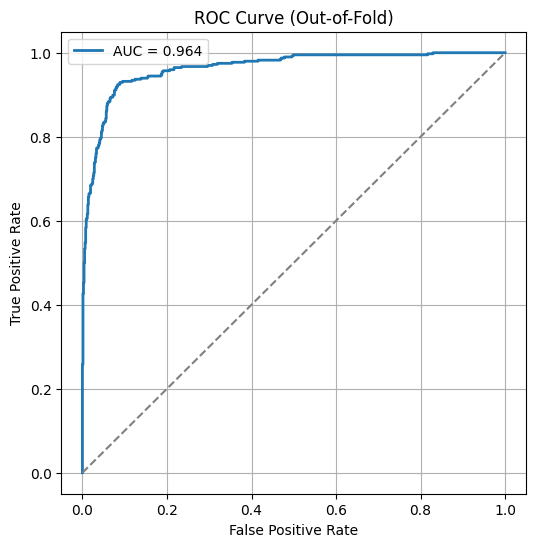

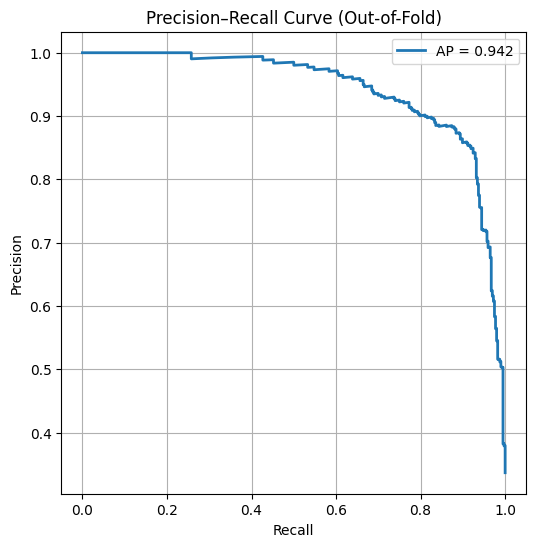

In [16]:
# ============================================================
# FULL PIPELINE
# SoftImpute + SVD + Logistic Regression
# Nested CV + Fβ-based thresholding
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
    average_precision_score
)

from fancyimpute import SoftImpute
from sklearn.decomposition import TruncatedSVD


# ============================================================
# 1) HELPER FUNCTIONS
# ============================================================

def create_proportional_mask(base_matrix, pairs_df, mask_indices, total_ones, random_state=42):
    rng = np.random.default_rng(random_state)
    Xm = base_matrix.astype(float).copy()

    held = pairs_df.iloc[mask_indices]
    held_ones = held[held["label"] == 1]

    for _, r in held_ones.iterrows():
        Xm[int(r["host_idx"]), int(r["parasite_idx"])] = np.nan

    if total_ones > 0 and len(held_ones) > 0:
        p = len(held_ones) / total_ones
        zeros = np.argwhere(Xm == 0.0)
        n_mask = int(p * len(zeros))
        if n_mask > 0:
            for idx in rng.choice(len(zeros), n_mask, replace=False):
                i, j = zeros[idx]
                Xm[i, j] = np.nan

    return Xm


def softimpute_then_svd(X_masked, shrinkage, rank):
    X_completed = SoftImpute(
        shrinkage_value=shrinkage,
        max_iters=200,
        convergence_threshold=1e-4,
        verbose=False
    ).fit_transform(X_masked)

    svd = TruncatedSVD(n_components=rank, random_state=42)
    U = svd.fit_transform(X_completed)
    V = svd.components_.T
    return U, V


def build_pair_features(pairs_df, U, V):
    feats = []
    for _, r in pairs_df.iterrows():
        ui = U[int(r["host_idx"])]
        vj = V[int(r["parasite_idx"])]
        feats.append(np.hstack([ui, vj, np.dot(ui, vj)]))
    return np.asarray(feats)


def choose_threshold_by_fbeta(y_true, scores, beta=4.0):
    """
    Choose threshold that maximizes F_beta on TRAIN data.
    beta = 1.0 → balanced classifier
    beta < 1.0 → favor precision (more 0s)
    beta > 1.0 → favor recall
    """
    precision, recall, thresholds = precision_recall_curve(y_true, scores)

    p = precision[1:]
    r = recall[1:]

    fbeta = (1 + beta**2) * (p * r) / (beta**2 * p + r + 1e-12)
    idx = np.argmax(fbeta)

    return float(thresholds[idx])


# ============================================================
# 2) PARAMETERS
# ============================================================

BETA = 4.0          # <<<<<< OPTION 1 CONTROL HERE
SHRINKAGE = 2.0
RANK = 20

outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

total_ones = int(np.sum(A == 1))


# ============================================================
# 3) STORAGE FOR OUT-OF-FOLD RESULTS
# ============================================================

all_test_y = []
all_test_prob = []


# ============================================================
# 4) OUTER CROSS-VALIDATION
# ============================================================

print("\nRunning CV with Fβ-based thresholding")

for fold, (train_idx, test_idx) in enumerate(
    outer_cv.split(cell_df, cell_df["label"]), start=1
):
    print(f"\n=== Fold {fold} ===")

    X_masked = create_proportional_mask(
        A, cell_df, test_idx, total_ones, random_state=42 + fold
    )

    train_df = cell_df.iloc[train_idx].reset_index(drop=True)
    test_df  = cell_df.iloc[test_idx]

    U, V = softimpute_then_svd(X_masked, SHRINKAGE, RANK)

    X_train = build_pair_features(train_df, U, V)
    y_train = train_df["label"].values.astype(int)

    X_test = build_pair_features(test_df, U, V)
    y_test = test_df["label"].values.astype(int)

    clf = LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        solver="lbfgs"
    )
    clf.fit(X_train, y_train)

    # ---------- Fβ THRESHOLD (KEY CHANGE)
    train_prob = clf.predict_proba(X_train)[:, 1]
    threshold = choose_threshold_by_fbeta(y_train, train_prob, beta=BETA)

    test_prob = clf.predict_proba(X_test)[:, 1]
    test_pred = (test_prob >= threshold).astype(int)

    print(
        f"AUC={roc_auc_score(y_test, test_prob):.3f} | "
        f"Recall={recall_score(y_test, test_pred):.3f} | "
        f"Precision={precision_score(y_test, test_pred, zero_division=0):.3f} | "
        f"thr={threshold:.4f} | "
        f"pred+={test_pred.sum()}/{y_test.sum()}"
    )

    all_test_y.append(y_test)
    all_test_prob.append(test_prob)


# ============================================================
# 5) CONCATENATE OUT-OF-FOLD RESULTS
# ============================================================

all_test_y = np.concatenate([np.asarray(y).ravel() for y in all_test_y])
all_test_prob = np.concatenate([np.asarray(p).ravel() for p in all_test_prob])


# ============================================================
# 6) CONFUSION MATRIX (GLOBAL, MEANINGFUL)
# ============================================================

global_threshold = np.median(all_test_prob)   # purely for visualization
y_pred = (all_test_prob >= global_threshold).astype(int)

cm = confusion_matrix(all_test_y, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Pred 0", "Pred 1"],
    yticklabels=["True 0", "True 1"]
)
plt.title("Confusion Matrix (Fβ thresholding)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


# ============================================================
# 7) ROC CURVE
# ============================================================

fpr, tpr, _ = roc_curve(all_test_y, all_test_prob)
roc_auc = roc_auc_score(all_test_y, all_test_prob)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Out-of-Fold)")
plt.legend()
plt.grid(True)
plt.show()


# ============================================================
# 8) PRECISION–RECALL CURVE
# ============================================================

precision, recall, _ = precision_recall_curve(all_test_y, all_test_prob)
ap = average_precision_score(all_test_y, all_test_prob)

plt.figure(figsize=(6,6))
plt.plot(recall, precision, lw=2, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Out-of-Fold)")
plt.legend()
plt.grid(True)
plt.show()


